# SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

# Load the images in grayscale
image1 = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)

# Compute SSIM between the two images
ssim_index, ssim_map = ssim(image1, image2, full=True)

print("SSIM:", ssim_index)


In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Example feature maps
feature_map1 = np.random.rand(64, 64)  # Example feature map
feature_map2 = np.random.rand(64, 64)  # Another example feature map

# Compute SSIM
ssim_index, ssim_map = ssim(feature_map1, feature_map2, full=True)

print("SSIM between feature maps:", ssim_index)


# Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example feature vectors
feature_vector1 = np.random.rand(128)  # 128-dimensional feature vector
feature_vector2 = np.random.rand(128)

# Calculate cosine similarity
cosine_sim = cosine_similarity([feature_vector1], [feature_vector2])

print("Cosine Similarity:", cosine_sim[0][0])


# ORB

In [ ]:
import cv2

def orb_feature_compare(imageA, imageB):
    # Convert to grayscale
    imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kpA, desA = orb.detectAndCompute(imageA, None)
    kpB, desB = orb.detectAndCompute(imageB, None)

    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desA, desB)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    return len(matches), matches

# Load images
imageA = cv2.imread('image1.webp')
imageB = cv2.imread('image2.webp')

# Compare features using ORB
matches_count, matches = orb_feature_compare(imageA, imageB)
print(f"Number of Matches: {matches_count}")

# Grad-CAM

In [ ]:
import torchvision
import matplotlib.pyplot as plt


def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)
    out = out.cpu().detach().numpy().transpose(1, 2, 0)

    return out

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(10,30))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap="gray" )
    plt.axis("off")

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm


probabilities = torch.nn.functional.softmax(imgs_out[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
imgs_out[0, top5_catid[0]].backward()
norm_img = norm_flat_image(imgs[0])
norm_grad = norm_flat_image(imgs[0].grad)
plot_maps(norm_grad, norm_img)

# Main

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import json
import argparse

from torchvision.models import wide_resnet50_2
from models.resnet import ResNet18
from torchvision.transforms import transforms
from dataset_loader import noise_loader, load_cifar10, load_svhn, load_cifar100, load_imagenet, load_mvtec_ad, load_visa
from torch.utils.data.dataset import Subset
import PIL
class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform, dataset):
        self.dataset = dataset
        self.data = np.load(imgs_path)
        self.targets = np.load(targets_path)

        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        img = self.transform(img)

        return img, target


def get_subclass_dataset(dataset, classes):
    if not isinstance(classes, list):
        classes = [classes]

    indices = []
    for idx, tgt in enumerate(dataset.targets):
        if tgt in classes:
            indices.append(idx)

    dataset = Subset(dataset, indices)
    return dataset




def loading_datasets(args, data_path, imagenet_path, transform):
    if args.dataset == 'cifar10':
        args.num_classes = 10
        train_loader, test_loader = load_cifar10(data_path,
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'svhn':
        args.num_classes = 10
        train_loader, test_loader = load_svhn(data_path, 
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'cifar100':
        args.num_classes = 20
        train_loader, test_loader = load_cifar100(data_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'imagenet30':
        args.num_classes = 30
        train_loader, test_loader = load_imagenet(imagenet_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'mvtec_ad':
        args.num_classes = 15
        train_loader, test_loader = load_mvtec_ad(data_path, 
                                                transforms=transform,
                                                resize=args.img_size,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)

    elif args.dataset == 'visa':
        args.num_classes = 12
        train_loader, test_loader = load_visa(data_path, 
                                            transforms=transform,
                                            resize=args.img_size,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    
    print("Start Loading noises")
    train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = noise_loader(
                    args,
                    transform=transform,
                    batch_size=args.batch_size,
                    one_class_idx=args.one_class_idx,
                    resize=args.img_size,
                    dataset=args.dataset,
                    preprocessing=args.preprocessing, 
                    k_pairs=args.k_pairs,
                    seed=args.seed)
    print("Loading noises finished!")

    return train_loader, test_loader, train_positives_loader, train_negetives_loader, test_positives_loader, test_negetives_loader


def parsing():
    parser = argparse.ArgumentParser(description='',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', default='cifar10', type=str, help='cifar10-cifar100-svhn')
    parser.add_argument('--one_class_idx', default=None, type=int, help='select one class index')
    parser.add_argument('--config', default=None, help='Config file for reading paths')
    parser.add_argument('--batch_size', '-b', type=int, default=1, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1, help='1')
    parser.add_argument('--img_size', default=32, type=int, help='image size selection')
    parser.add_argument('--preprocessing', default='clip', type=str, help='which preprocessing use for noise order')
    parser.add_argument('--k_pairs', default=1, type=int, help='Selecting multiple pairs for contrastive loss')
    parser.add_argument('--device', type=str, default="cuda", help='cuda or cpu.')
    args = parser.parse_args()

    return args





import sys
sys.argv = ["", "--one_class_idx", "0", "--dataset", "cifar10", "--batch_size", "1"]

with open('config.json', 'r') as config_file:
    config = json.load(config_file)



root_path = config['root_path']
data_path = config['data_path']
imagenet_path = config['imagenet_path']
args = parsing()
args.config = config

import pickle 
with open(f'./ranks/clip/{args.dataset}/wasser_dist_softmaxed.pkl', 'rb') as file:
    probs = pickle.load(file)    

## Clip

In [ ]:
from clip import clip
model, transform = clip.load("ViT-L/14", device=args.device)

## Resnet-50 Wide

In [2]:
model = wide_resnet50_2("IMAGENET1K_V2")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize(256),
                                            torchvision.transforms.CenterCrop(224)])

# Recursive function to register hooks for all layers, including nested ones
def register_hooks(model, feature_maps):
    hook_handles = []

    def hook_fn(module, input, output, layer_name):
        feature_maps[layer_name] = output

    def recursive_hook_register(module, parent_name=""):
        for name, sub_module in module.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            handle = sub_module.register_forward_hook(
                lambda module, input, output, name=full_name: hook_fn(module, input, output, name)
            )
            hook_handles.append(handle)
            # Recursively register hooks for nested layers
            recursive_hook_register(sub_module, full_name)

    recursive_hook_register(model)
    return hook_handles


# Forward pass and capture feature maps
def get_all_feature_maps(model, img_tensor):
    feature_maps = {}
    hook_handles = register_hooks(model, feature_maps)

    # Forward pass
    model(img_tensor)

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    return feature_maps

C:\Users\Mohammad\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


## Run

In [14]:
probs[args.one_class_idx]

{'gaussian_blur': 0.092342176,
 'flip': 0.092739664,
 'snow': 0.096888825,
 'rot90': 0.100596465,
 'rot270': 0.10067636,
 'color_jitter': 0.100792915,
 'random_crop': 0.10263214,
 'jpeg_compression': 0.10320303,
 'gaussian_noise': 0.104047686,
 'glass_blur': 0.106080756}

In [ ]:
train_loader, test_loader, train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = loading_datasets(args, data_path, imagenet_path, transform=transform)

import os
np_train_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1/labels.npy')
np_test_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5/labels.npy')
np_train_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1')
np_test_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5')
np_test_img_path = os.path.join(np_test_root_path, noise + '.npy')

loading cifar10
Files already downloaded and verified
Files already downloaded and verified
Start Loading noises
Creating noises loader
Selecting flip as positive pair for class 0
Selecting glass_blur as negetive pair for class 0
Loading noises finished!


In [ ]:
imgs_out = []
p_imgs_out = []
n_imgs_out = []
model = model.to(args.device)
model.eval()

iter = 0
for (normal, p_data, n_data) in zip(train_loader, train_positives_loader[0], train_negetives_loader[0]):
    imgs, labels = normal
    p_imgs, p_label = p_data
    n_imgs, n_label = n_data
    assert torch.equal(torch.squeeze(labels), torch.squeeze(p_label)), f"The labels of positives images do not match to noraml images, {torch.squeeze(labels)}, {torch.squeeze(p_label)}"
    assert torch.equal(torch.squeeze(labels), torch.squeeze(n_label)), f"The labels of negatives images do not match to noraml images, {torch.squeeze(labels)}, {torch.squeeze(n_label)}"
    imgs, labels = imgs.to(args.device), labels.to(args.device)
    p_imgs = p_imgs.to(args.device)
    n_imgs = n_imgs.to(args.device)

    imgs.requires_grad = True
    p_imgs.requires_grad = True
    n_imgs.requires_grad = True

    # imgs_out = model.encode_image(imgs)
    # p_imgs_out = model.encode_image(p_imgs)
    # n_imgs_out = model.encode_image(n_imgs)

    # imgs_out.append(model.encode_image(imgs))
    # p_imgs_out.append(model.encode_image(p_imgs))
    # n_imgs_out.append(model.encode_image(n_imgs))

    # imgs_out = model(imgs)
    # p_imgs_out = model(p_imgs)
    # n_imgs_out = model(n_imgs)

    imgs_out.append(get_all_feature_maps(model, imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
    p_imgs_out.append(get_all_feature_maps(model, p_imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
    n_imgs_out.append(get_all_feature_maps(model, n_imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
    if iter > 128:
        break
    iter += 1

In [5]:
x = np.concatenate((np.array(imgs_out), np.array(p_imgs_out)), axis=0)
# x = np.concatenate((imgs_out[0].cpu().detach().numpy(), p_imgs_out.cpu().detach().numpy()), axis=0)
y = np.concatenate((np.ones(len(imgs_out)), np.zeros(len(p_imgs_out))), axis=0)

In [6]:
x.shape, y.shape

((260, 2048), (260,))

In [7]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px 

In [8]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()
df["y"] = y
df["component_1"] = z[:,0]
df["component_2"] = z[:,1]
label_str = []
for l in df.y.tolist():
    if l == 1:
        label_str.append('0')
    else:
        label_str.append('1')

fig = px.scatter(data_frame=df, x="component_1", y="component_2", color=label_str,
           labels={
                     "component_1": "Component 1",
                     "component_2": "Component 2",
                 },
            # title="",
            width=1024, height=1024)

fig.update_layout(
    font=dict(
        size=22,  # Set the font size here
    )
)
fig.show()
# fig.write_image(original_path+prefix_path+config_path+"{}_vs_{}_tsne.png".format(class1, class2))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 260 samples in 0.001s...
[t-SNE] Computed neighbors for 260 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 260 / 260
[t-SNE] Mean sigma: 5.731060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.045128
[t-SNE] KL divergence after 1000 iterations: 0.479017


In [9]:
x = np.concatenate((np.array(imgs_out), np.array(n_imgs_out)), axis=0)
y = np.concatenate((np.ones(len(imgs_out)), np.zeros(len(n_imgs_out))), axis=0)

tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()
df["y"] = y
df["component_1"] = z[:,0]
df["component_2"] = z[:,1]
label_str = []
for l in df.y.tolist():
    if l == 1:
        label_str.append('0')
    else:
        label_str.append('1')

fig = px.scatter(data_frame=df, x="component_1", y="component_2", color=label_str,
           labels={
                     "component_1": "Component 1",
                     "component_2": "Component 2",
                 },
            # title="",
            width=1024, height=1024)

fig.update_layout(
    font=dict(
        size=22,  # Set the font size here
    )
)
fig.show()
# fig.write_image(original_path+prefix_path+config_path+"{}_vs_{}_tsne.png".format(class1, class2))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 260 samples in 0.001s...
[t-SNE] Computed neighbors for 260 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 260 / 260
[t-SNE] Mean sigma: 4.082521
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.915024
[t-SNE] KL divergence after 1000 iterations: 0.730509


# TSNE-plot

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import json
import argparse

from torchvision.models import wide_resnet50_2
from models.resnet import ResNet18
from torchvision.transforms import transforms
from dataset_loader import noise_loader, load_cifar10, load_svhn, load_cifar100, load_imagenet, load_mvtec_ad, load_visa
from torch.utils.data.dataset import Subset
import PIL
class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform, dataset):
        self.dataset = dataset
        self.data = np.load(imgs_path)
        self.targets = np.load(targets_path)

        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        img = self.transform(img)

        return img, target


def get_subclass_dataset(dataset, classes):
    if not isinstance(classes, list):
        classes = [classes]

    indices = []
    for idx, tgt in enumerate(dataset.targets):
        if tgt in classes:
            indices.append(idx)

    dataset = Subset(dataset, indices)
    return dataset




def loading_datasets(args, data_path, imagenet_path, transform):
    if args.dataset == 'cifar10':
        args.num_classes = 10
        train_loader, test_loader = load_cifar10(data_path,
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'svhn':
        args.num_classes = 10
        train_loader, test_loader = load_svhn(data_path, 
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'cifar100':
        args.num_classes = 20
        train_loader, test_loader = load_cifar100(data_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'imagenet30':
        args.num_classes = 30
        train_loader, test_loader = load_imagenet(imagenet_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'mvtec_ad':
        args.num_classes = 15
        train_loader, test_loader = load_mvtec_ad(data_path, 
                                                transforms=transform,
                                                resize=args.img_size,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)

    elif args.dataset == 'visa':
        args.num_classes = 12
        train_loader, test_loader = load_visa(data_path, 
                                            transforms=transform,
                                            resize=args.img_size,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    
    print("Start Loading noises")
    train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = noise_loader(
                    args,
                    transform=transform,
                    batch_size=args.batch_size,
                    one_class_idx=args.one_class_idx,
                    resize=args.img_size,
                    dataset=args.dataset,
                    preprocessing=args.preprocessing, 
                    k_pairs=args.k_pairs,
                    seed=args.seed)
    print("Loading noises finished!")

    return train_loader, test_loader, train_positives_loader, train_negetives_loader, test_positives_loader, test_negetives_loader


def parsing():
    parser = argparse.ArgumentParser(description='',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', default='cifar10', type=str, help='cifar10-cifar100-svhn')
    parser.add_argument('--one_class_idx', default=None, type=int, help='select one class index')
    parser.add_argument('--config', default=None, help='Config file for reading paths')
    parser.add_argument('--batch_size', '-b', type=int, default=1, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1, help='1')
    parser.add_argument('--img_size', default=32, type=int, help='image size selection')
    parser.add_argument('--preprocessing', default='clip', type=str, help='which preprocessing use for noise order')
    parser.add_argument('--k_pairs', default=1, type=int, help='Selecting multiple pairs for contrastive loss')
    parser.add_argument('--device', type=str, default="cuda", help='cuda or cpu.')
    args = parser.parse_args()

    return args





import sys
sys.argv = ["", "--one_class_idx", "0", "--dataset", "cifar10", "--batch_size", "1"]

with open('config.json', 'r') as config_file:
    config = json.load(config_file)



root_path = config['root_path']
data_path = config['data_path']
imagenet_path = config['imagenet_path']
args = parsing()
args.config = config


model = wide_resnet50_2("IMAGENET1K_V2")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize(256),
                                            torchvision.transforms.CenterCrop(224)])

# Recursive function to register hooks for all layers, including nested ones
def register_hooks(model, feature_maps):
    hook_handles = []

    def hook_fn(module, input, output, layer_name):
        feature_maps[layer_name] = output

    def recursive_hook_register(module, parent_name=""):
        for name, sub_module in module.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            handle = sub_module.register_forward_hook(
                lambda module, input, output, name=full_name: hook_fn(module, input, output, name)
            )
            hook_handles.append(handle)
            # Recursively register hooks for nested layers
            recursive_hook_register(sub_module, full_name)

    recursive_hook_register(model)
    return hook_handles


# Forward pass and capture feature maps
def get_all_feature_maps(model, img_tensor):
    feature_maps = {}
    hook_handles = register_hooks(model, feature_maps)

    # Forward pass
    model(img_tensor)

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    return feature_maps

C:\Users\Mohammad\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
import pickle 
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px 
with open(f'./ranks/clip/{args.dataset}/wasser_dist_softmaxed.pkl', 'rb') as file:
    probs = pickle.load(file)    

train_loader, test_loader, train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = loading_datasets(args, data_path, imagenet_path, transform=transform)



import os
from torch.utils.data import DataLoader
np_train_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1/labels.npy')
np_test_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5/labels.npy')
np_train_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1')
np_test_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5')

for noise in probs[args.one_class_idx]:
    np_test_img_path = os.path.join(np_test_root_path, noise + '.npy')
    np_train_img_path = os.path.join(np_train_root_path, noise + '.npy')
    train_positives_datasets = load_np_dataset(np_train_img_path, np_train_target_path, transform, None) 
    train_positives_datasets = get_subclass_dataset(train_positives_datasets, args.one_class_idx)
    gn = torch.Generator().manual_seed(args.seed)
    train_positives_loader = DataLoader(train_positives_datasets, shuffle=True, generator=gn, batch_size=args.batch_size)

    imgs_out = []
    aug_imgs_out = []
    model = model.to(args.device)
    model.eval()

    iter = 0
    for (normal, p_data) in zip(train_loader, train_positives_loader):
        imgs, labels = normal
        p_imgs, p_label = p_data
        assert torch.equal(torch.squeeze(labels), torch.squeeze(p_label)), f"The labels of positives images do not match to noraml images, {torch.squeeze(labels)}, {torch.squeeze(p_label)}"
        imgs, labels = imgs.to(args.device), labels.to(args.device)
        p_imgs = p_imgs.to(args.device)

        # imgs.requires_grad = True
        # p_imgs.requires_grad = True

        # imgs_out = model.encode_image(imgs)
        # p_imgs_out = model.encode_image(p_imgs)
        # n_imgs_out = model.encode_image(n_imgs)

        # imgs_out.append(model.encode_image(imgs))
        # p_imgs_out.append(model.encode_image(p_imgs))
        # n_imgs_out.append(model.encode_image(n_imgs))

        # imgs_out = model(imgs)
        # p_imgs_out = model(p_imgs)
        # n_imgs_out = model(n_imgs)

        imgs_out.append(get_all_feature_maps(model, imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
        aug_imgs_out.append(get_all_feature_maps(model, p_imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
        if iter > 128:
            break
        iter += 1



    x = np.concatenate((np.array(imgs_out), np.array(aug_imgs_out)), axis=0)
    y = np.concatenate((np.ones(len(imgs_out)), np.zeros(len(aug_imgs_out))), axis=0)

    tsne = TSNE(n_components=2, verbose=1, random_state=123, learning_rate='auto')
    z = tsne.fit_transform(x) 
    df = pd.DataFrame()
    df["y"] = y
    df["component_1"] = z[:,0]
    df["component_2"] = z[:,1]
    label_str = []
    for l in df.y.tolist():
        if l == 1:
            label_str.append('0')
        else:
            label_str.append('1')

    fig = px.scatter(data_frame=df, x="component_1", y="component_2", color=label_str,
            labels={
                        "component_1": "Component 1",
                        "component_2": "Component 2",
                    },
                title=f"Class {args.one_class_idx} normal vs {noise}",
                width=1024, height=1024)

    fig.update_layout(
        font=dict(
            size=22,  # Set the font size here
        )
    )
    # fig.show()
    fig.write_image("class_{}_normal_vs_{}_tsne.png".format(args.one_class_idx, noise))

loading cifar10
Files already downloaded and verified
Files already downloaded and verified
Start Loading noises
Creating noises loader
Selecting flip as positive pair for class 0
Selecting glass_blur as negetive pair for class 0
Loading noises finished!
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 260 samples in 0.001s...
[t-SNE] Computed neighbors for 260 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 260 / 260
[t-SNE] Mean sigma: 5.946383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.628933
[t-SNE] KL divergence after 1000 iterations: 0.456446


# GMSD

In [38]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import json
import argparse

from torchvision.models import wide_resnet50_2
from models.resnet import ResNet18
from torchvision.transforms import transforms
from dataset_loader import noise_loader, load_cifar10, load_svhn, load_cifar100, load_imagenet, load_mvtec_ad, load_visa
from torch.utils.data.dataset import Subset
import PIL
class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform, dataset):
        self.dataset = dataset
        self.data = np.load(imgs_path)
        self.targets = np.load(targets_path)

        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        img = self.transform(img)

        return img, target


def get_subclass_dataset(dataset, classes):
    if not isinstance(classes, list):
        classes = [classes]

    indices = []
    for idx, tgt in enumerate(dataset.targets):
        if tgt in classes:
            indices.append(idx)

    dataset = Subset(dataset, indices)
    return dataset




def loading_datasets(args, data_path, imagenet_path, transform):
    if args.dataset == 'cifar10':
        args.num_classes = 10
        train_loader, test_loader = load_cifar10(data_path,
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'svhn':
        args.num_classes = 10
        train_loader, test_loader = load_svhn(data_path, 
                                            transforms=transform,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    elif args.dataset == 'cifar100':
        args.num_classes = 20
        train_loader, test_loader = load_cifar100(data_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'imagenet30':
        args.num_classes = 30
        train_loader, test_loader = load_imagenet(imagenet_path, 
                                                transforms=transform,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)
    elif args.dataset == 'mvtec_ad':
        args.num_classes = 15
        train_loader, test_loader = load_mvtec_ad(data_path, 
                                                transforms=transform,
                                                resize=args.img_size,
                                                batch_size=args.batch_size,
                                                one_class_idx=args.one_class_idx,
                                                seed=args.seed)

    elif args.dataset == 'visa':
        args.num_classes = 12
        train_loader, test_loader = load_visa(data_path, 
                                            transforms=transform,
                                            resize=args.img_size,
                                            batch_size=args.batch_size,
                                            one_class_idx=args.one_class_idx,
                                            seed=args.seed)
    
    print("Start Loading noises")
    train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = noise_loader(
                    args,
                    transform=transform,
                    batch_size=args.batch_size,
                    one_class_idx=args.one_class_idx,
                    resize=args.img_size,
                    dataset=args.dataset,
                    preprocessing=args.preprocessing, 
                    k_pairs=args.k_pairs,
                    seed=args.seed)
    print("Loading noises finished!")

    return train_loader, test_loader, train_positives_loader, train_negetives_loader, test_positives_loader, test_negetives_loader


def parsing():
    parser = argparse.ArgumentParser(description='',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', default='cifar10', type=str, help='cifar10-cifar100-svhn')
    parser.add_argument('--one_class_idx', default=None, type=int, help='select one class index')
    parser.add_argument('--config', default=None, help='Config file for reading paths')
    parser.add_argument('--batch_size', '-b', type=int, default=1, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1, help='1')
    parser.add_argument('--img_size', default=32, type=int, help='image size selection')
    parser.add_argument('--preprocessing', default='clip', type=str, help='which preprocessing use for noise order')
    parser.add_argument('--k_pairs', default=1, type=int, help='Selecting multiple pairs for contrastive loss')
    parser.add_argument('--device', type=str, default="cuda", help='cuda or cpu.')
    args = parser.parse_args()

    return args





import sys
sys.argv = ["", "--one_class_idx", "1", "--dataset", "cifar10", "--batch_size", "16"]

with open('config.json', 'r') as config_file:
    config = json.load(config_file)



root_path = config['root_path']
data_path = config['data_path']
imagenet_path = config['imagenet_path']
args = parsing()
args.config = config


model = wide_resnet50_2("IMAGENET1K_V2")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize(256),
                                            torchvision.transforms.CenterCrop(224)])

# Recursive function to register hooks for all layers, including nested ones
def register_hooks(model, feature_maps):
    hook_handles = []

    def hook_fn(module, input, output, layer_name):
        feature_maps[layer_name] = output

    def recursive_hook_register(module, parent_name=""):
        for name, sub_module in module.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            handle = sub_module.register_forward_hook(
                lambda module, input, output, name=full_name: hook_fn(module, input, output, name)
            )
            hook_handles.append(handle)
            # Recursively register hooks for nested layers
            recursive_hook_register(sub_module, full_name)

    recursive_hook_register(model)
    return hook_handles


# Forward pass and capture feature maps
def get_all_feature_maps(model, img_tensor):
    feature_maps = {}
    hook_handles = register_hooks(model, feature_maps)

    # Forward pass
    model(img_tensor)

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    return feature_maps

import pickle 
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px 
with open(f'./ranks/clip/{args.dataset}/wasser_dist_softmaxed.pkl', 'rb') as file:
    probs = pickle.load(file)    

train_loader, test_loader, train_positives_loader, train_negetives_loader,\
    test_positives_loader, test_negetives_loader = loading_datasets(args, data_path, imagenet_path, transform=transform)


noise = 'rot90'
import os
from torch.utils.data import DataLoader
np_train_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1/labels.npy')
np_test_target_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5/labels.npy')
np_train_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Train_s1')
np_test_root_path = os.path.join(args.config['generalization_path'], f'{args.dataset}_Test_s5')


np_test_img_path = os.path.join(np_test_root_path, noise + '.npy')
np_train_img_path = os.path.join(np_train_root_path, noise + '.npy')
train_positives_datasets = load_np_dataset(np_train_img_path, np_train_target_path, transform, None) 
train_positives_datasets = get_subclass_dataset(train_positives_datasets, args.one_class_idx)
gn = torch.Generator().manual_seed(args.seed)
train_positives_loader = DataLoader(train_positives_datasets, shuffle=True, generator=gn, batch_size=args.batch_size)

imgs_out = []
aug_imgs_out = []
model = model.to(args.device)
model.eval()

iter = 0
for (normal, p_data) in zip(train_loader, train_positives_loader):
    imgs, labels = normal
    p_imgs, p_label = p_data
    assert torch.equal(torch.squeeze(labels), torch.squeeze(p_label)), f"The labels of positives images do not match to noraml images, {torch.squeeze(labels)}, {torch.squeeze(p_label)}"
    imgs, labels = imgs.to(args.device), labels.to(args.device)
    p_imgs = p_imgs.to(args.device)

    # imgs.requires_grad = True
    # p_imgs.requires_grad = True

    # imgs_out = model.encode_image(imgs)
    # p_imgs_out = model.encode_image(p_imgs)
    # n_imgs_out = model.encode_image(n_imgs)

    # imgs_out.append(model.encode_image(imgs))
    # p_imgs_out.append(model.encode_image(p_imgs))
    # n_imgs_out.append(model.encode_image(n_imgs))

    # imgs_out = model(imgs)
    # p_imgs_out = model(p_imgs)
    # n_imgs_out = model(n_imgs)

    imgs_out.append(get_all_feature_maps(model, imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
    aug_imgs_out.append(get_all_feature_maps(model, p_imgs)['avgpool'].view(-1, 2048).cpu().detach().numpy()[0])
    # if iter > 128:
    break
    # iter += 1

import cv2
import numpy as np
from scipy.ndimage import sobel

def gmsd(ref_image, dist_image):
    """
    Compute the GMSD between two images.

    Parameters:
        ref_image (ndarray): The reference (original) image.
        dist_image (ndarray): The distorted image to compare.

    Returns:
        gmsd_score (float): The GMSD score between the two images.
    """

    # Convert images to grayscale if they are in color
    if ref_image.ndim == 3:
        ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2GRAY)
    if dist_image.ndim == 3:
        dist_image = cv2.cvtColor(dist_image, cv2.COLOR_BGR2GRAY)

    # Normalize images to [0, 1] range
    ref_image = ref_image.astype(np.float32) / 255.0
    dist_image = dist_image.astype(np.float32) / 255.0

    # Compute gradient magnitude using Sobel filter
    def gradient_magnitude(img):
        grad_x = sobel(img, axis=1, mode='reflect')
        grad_y = sobel(img, axis=0, mode='reflect')
        return np.sqrt(grad_x**2 + grad_y**2)

    # Get gradient magnitude of both images
    grad_ref = gradient_magnitude(ref_image)
    grad_dist = gradient_magnitude(dist_image)

    # Compute the gradient similarity map
    epsilon = 1e-4  # Small constant to avoid division by zero
    gms_map = (2 * grad_ref * grad_dist + epsilon) / (grad_ref**2 + grad_dist**2 + epsilon)

    # Calculate GMSD as the standard deviation of the GMS map
    gmsd_score = np.std(gms_map)
    return gmsd_score




loading cifar10
Files already downloaded and verified
Files already downloaded and verified
Start Loading noises
Creating noises loader
Selecting flip as positive pair for class 1
Selecting glass_blur as negetive pair for class 1
Loading noises finished!


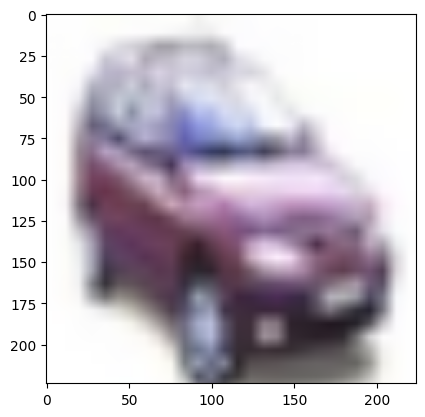

In [39]:
plt.imshow(imgs[0].permute(1,2,0).cpu().detach().numpy())

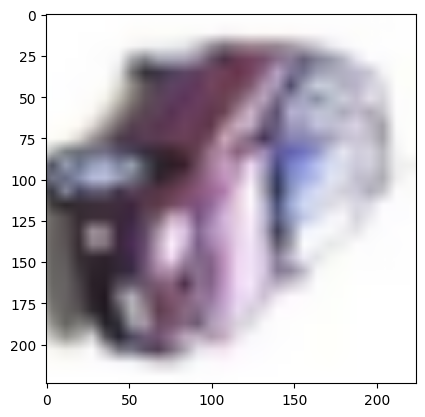

In [40]:
plt.imshow(p_imgs[0].permute(1,2,0).cpu().detach().numpy())

In [41]:
gmsd(imgs[0].permute(1,2,0).cpu().detach().numpy(), p_imgs[0].permute(1,2,0).cpu().detach().numpy())

0.006490353

In [42]:
gmsd(imgs[0].permute(1,2,0).cpu().detach().numpy(), p_imgs[2].permute(1,2,0).cpu().detach().numpy())

0.006234439

In [43]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute SSIM
ssim_index, ssim_map = ssim((imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), (p_imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), full=True, channel_axis=2)
print("SSIM between feature maps:", ssim_index)

SSIM between feature maps: 0.37018510251120545


In [45]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute SSIM
ssim_index, ssim_map = ssim((imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), (imgs[2].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), full=True, channel_axis=2)

print("SSIM between feature maps:", ssim_index)

SSIM between feature maps: 0.3399806091134927


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity
cosine_sim = cosine_similarity([imgs[0].permute(1,2,0).cpu().detach().numpy().flatten()], [p_imgs[0].permute(1,2,0).cpu().detach().numpy().flatten()])

print("Cosine Similarity:", cosine_sim[0][0])


Cosine Similarity: 0.8912575


In [48]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity
cosine_sim = cosine_similarity([imgs[0].permute(1,2,0).cpu().detach().numpy().flatten()], [imgs[2].permute(1,2,0).cpu().detach().numpy().flatten()])

print("Cosine Similarity:", cosine_sim[0][0])


Cosine Similarity: 0.8834989


In [19]:
import cv2

def orb_similarity(img1, img2):
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # Create a BFMatcher object with Hamming distance and crossCheck
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Count the number of good matches
    good_matches = [m for m in matches if m.distance < 50]
    
    # Similarity score based on the number of good matches
    similarity_score = len(good_matches)
    return similarity_score


In [49]:
orb_similarity((imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), (p_imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'))

43

In [51]:
orb_similarity((imgs[0].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'), (imgs[2].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8'))

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\batch_distance.cpp:275: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'cv::batchDistance'
